In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
features = []
with open('data/features', 'rb') as f:
    features = np.load(f)

In [5]:
labels = []

with open('data/train_labels', 'rb') as f:
    labels = np.load(f)

In [9]:
X = pd.DataFrame(features)
y = pd.Series(labels)

**Случайный лес**

Его трудно переобучить и он хорошо справляется с нахождением нелинейных зависимостей. Часто он не сильно уступает в качестве сложным нейронным сетям. Помимо этого, уже обученный лес очень быстро делает предсказания.

Воспользуемся готовой реализацией от sklearn. Необходимо подобрать оптимальные гиперпараметры - это в первую очередь max_depth каждого дерева и n_estimators - количество деревьев

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [16]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [50, 100, 150, 200, 350, 400]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 41.74% with 350 trees


Text(0.5, 0, 'N_estimators')

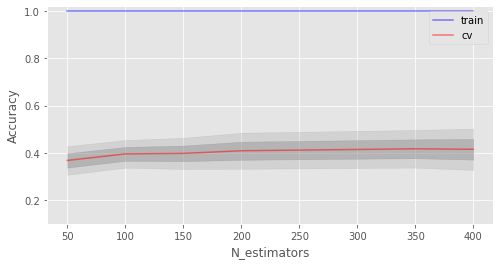

In [19]:
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.1,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

Утверждается, что оптимальное значение в сетке поиска - 350. Можно было бы перебрать больше значений в районе 350, но видно, что после 200 accuracy выходит на плато, так что можно не исследовать дальше

In [20]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=350, random_state=42, n_jobs=-1, oob_score=True, 
                                 max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 41.81% with 17 max_depth


Text(0.5, 0, 'Max_depth')

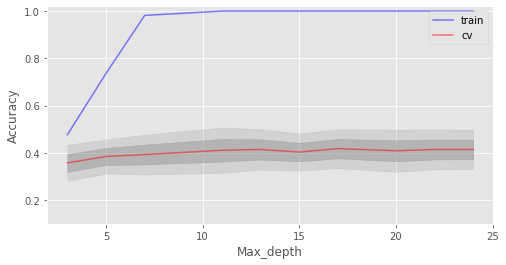

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.1,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

С max_depth аналогичная ситуация. После 10 модель выходит на плато. Оптимальное значение достигается на 17

Итоговая accuracy - 40,8%. Это может показаться небольшим, но меток классов 8, то есть "подбрасывание монетки" дало бы нам только 12.5%. В других работах на аналогичных данных достигается accuracy в 60% https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

**Градиентный бустинг**

Родственная модель к случайному лесу, но которая как правило всё-таки показывает себя лучше и эффективнее. К ней применим аналогичное исследование

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(warm_start=True, max_depth=5, 
                                 learning_rate=0.1, subsample=1,
                                n_estimators=1000)

In [23]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [2, 3, 5, 7, 11, 13]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = GradientBoostingClassifier(warm_start=True, max_depth=max_depth, 
                                 learning_rate=0.1)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

KeyboardInterrupt: 

In [ ]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100, 150, 200, 350, 400]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = GradientBoostingClassifier(warm_start=True, max_depth=5, 
                                 learning_rate=0.1, n_estimators=ntrees)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

**Многослойная сеть**

In [ ]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y)

clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(1000, 20), 
                    max_iter=100, warm_start=True)
history = clf.fit(X_train, y_train)

clf.score(X_train, y_train)
clf.score(X_test, y_test)